# Transfer Learning
### Projeto Final da Disciplina de Aprendizado de Máquina

Professor: Ivanovitch Medeiros

Mestranda: Giovanna Assunção Pereira Soares

#### Início: Importando bibliotecas, kagglehub, e atualizando tensorflow

In [ ]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arifmia/brain-tumor-mri-image-dataset-updated")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arifmia/brain-tumor-mri-image-dataset-updated/versions/1


In [ ]:
!pip install --upgrade tensorflow

#### Dataset e mais importações
Precisamos criar o novo diretório para nossos dataset de treinamento, validação e teste

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Diretórios originais
train_dir = '/root/.cache/kagglehub/datasets/arifmia/brain-tumor-mri-image-dataset-updated/versions/1/image_dataset/Training'
test_dir = '/root/.cache/kagglehub/datasets/arifmia/brain-tumor-mri-image-dataset-updated/versions/1/image_dataset/Testing'

# Diretórios para os novos conjuntos
base_output_dir = '/root/new_dataset_split'
train_output_dir = os.path.join(base_output_dir, 'Training')
val_output_dir = os.path.join(base_output_dir, 'Validation')
test_output_dir = os.path.join(base_output_dir, 'Testing')

# Criar os novos diretórios
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(val_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Função para juntar as imagens e dividir em proporções
def combine_and_split_data(train_dir, test_dir, train_output, val_output, test_output, train_split=0.8, val_split=0.1):
    for class_name in os.listdir(train_dir):
        # Diretórios das classes
        class_train_path = os.path.join(train_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        # Combinar todas as imagens de treinamento e teste
        all_images = []
        if os.path.isdir(class_train_path):
            all_images += [os.path.join(class_train_path, img) for img in os.listdir(class_train_path)]
        if os.path.isdir(class_test_path):
            all_images += [os.path.join(class_test_path, img) for img in os.listdir(class_test_path)]

        # Divisão dos dados
        train_images, temp_images = train_test_split(all_images, test_size=(1 - train_split), random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=(val_split / (1 - train_split)), random_state=42)

        # Criar subdiretórios por classe nos novos conjuntos
        os.makedirs(os.path.join(train_output, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_output, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_output, class_name), exist_ok=True)

        # Mover as imagens para os novos diretórios
        for img in train_images:
            shutil.copy(img, os.path.join(train_output, class_name, os.path.basename(img)))
        for img in val_images:
            shutil.copy(img, os.path.join(val_output, class_name, os.path.basename(img)))
        for img in test_images:
            shutil.copy(img, os.path.join(test_output, class_name, os.path.basename(img)))

# Combinar e dividir os dados
combine_and_split_data(train_dir, test_dir, train_output_dir, val_output_dir, test_output_dir)

print("Divisão concluída. Dados salvos em:", base_output_dir)

Divisão concluída. Dados salvos em: /root/new_dataset_split


In [ ]:
# Diretórios para os novos conjuntos de dados
base_output_dir = '/root/new_dataset_split'
train_dir = f"{base_output_dir}/Training"
val_dir = f"{base_output_dir}/Validation"
test_dir = f"{base_output_dir}/Testing"

# Normalização e aumento de dados para treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalização para validação e teste
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Redimensionar as imagens para 224x224
    batch_size=32,
    class_mode='categorical',  # Classificação para múltiplas classes
    shuffle=True  # Misturar os dados
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Manter ordem fixa para avaliação
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Manter ordem fixa para avaliação
)

# Exibir as classes detectadas
print("Classes de treinamento:", train_generator.class_indices)
print("Classes de validação:", val_generator.class_indices)
print("Classes de teste:", test_generator.class_indices)



Found 2548 images belonging to 4 classes.
Found 323 images belonging to 4 classes.
Found 330 images belonging to 4 classes.
Classes de treinamento: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Classes de validação: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Classes de teste: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


#### FEATURE EXTRACTION
Utiliza o modelo pré-treinado como extrator de características, sem atualizar camadas convolucionais, e treinado apenas as novas camadas.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# Carregar o modelo pré-treinado MobileNetV2 (sem as camadas finais de classificação)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas convolucionais da MobileNetV2
base_model.trainable = False

# Criar o modelo final
model = models.Sequential([
    base_model,  # Modelo pré-treinado MobileNetV2
    layers.GlobalAveragePooling2D(),  # Pooling para reduzir a dimensão
    layers.Dense(512, activation='relu'),  # Camada densa com 512 neurônios
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Camada final com número de classes
])

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

# Treinar o modelo com os dados de treinamento e validação
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.5937 - loss: 1.1711 - val_accuracy: 0.7245 - val_loss: 0.7654
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.7990 - loss: 0.5106 - val_accuracy: 0.7492 - val_loss: 0.6012
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8374 - loss: 0.4388 - val_accuracy: 0.7399 - val_loss: 0.7819
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8411 - loss: 0.4022 - val_accuracy: 0.8111 - val_loss: 0.4678
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8654 - loss: 0.3613 - val_accuracy: 0.8019 - val_loss: 0.5136
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8721 - loss: 0.3351 - val_accuracy: 0.8111 - val_loss: 0.4976
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8655 - loss: 0.3452 - val_accuracy: 0.8235 - val_loss: 0.4502
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8860 - loss: 0.3019 - val_accuracy: 0.8359 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
Acurácia do modelo no conjunto de teste: 0.8424


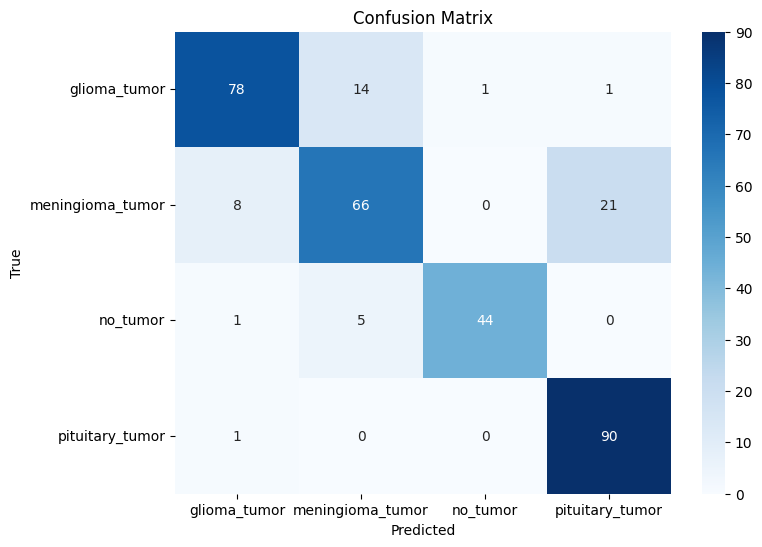

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.83      0.86        94
meningioma_tumor       0.78      0.69      0.73        95
        no_tumor       0.98      0.88      0.93        50
 pituitary_tumor       0.80      0.99      0.89        91

        accuracy                           0.84       330
       macro avg       0.86      0.85      0.85       330
    weighted avg       0.85      0.84      0.84       330



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Fazendo previsões no conjunto de teste
test_predictions = model.predict(test_generator, verbose=1)

# Convertendo as previsões para as classes
predicted_classes = np.argmax(test_predictions, axis=1)

# Obtendo os rótulos reais
true_classes = test_generator.classes

# Acurácia
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Acurácia do modelo no conjunto de teste: {accuracy:.4f}")

# Matriz de Confusão
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de Classificação (Precision, Recall, F1-Score)
class_report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)


#### FINE TUNING
Já durante o fine-tuning, se descongela algumas camadas superiores para que o modelo seja capaz de aprender representações mais específicas do conjunto de dados.

In [ ]:
from tensorflow.keras import optimizers
# Fine-tuning: Descongelar as camadas superiores do modelo base
base_model.trainable = True

# Congelar as camadas anteriores do modelo base (43 primeiras camadas)
fine_tune_at = -10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar o modelo para o fine-tuning
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Treinar novamente com o fine-tuning
history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 1,390,404 (5.30 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6136 - loss: 0.9875 - val_accuracy: 0.8421 - val_loss: 0.5068
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8041 - loss: 0.4929 - val_accuracy: 0.8328 - val_loss: 0.5201
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8379 - loss: 0.4182 - val_accuracy: 0.8235 - val_loss: 0.5154
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8586 - loss: 0.4020 - val_accuracy: 0.8359 - val_loss: 0.5006
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8826 - loss: 0.3279 - val_accuracy: 0.8421 - val_loss: 0.4881
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8720 - loss: 0.3493 - val_accuracy: 0.8483 - val_loss: 0.4519
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.8749 - loss: 0.3092 - val_accuracy: 0.8483 - val_loss: 0.4474
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8861 - loss: 0.3177 - val_accuracy: 0.8452 - v

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Acurácia do modelo no conjunto de teste: 0.8515


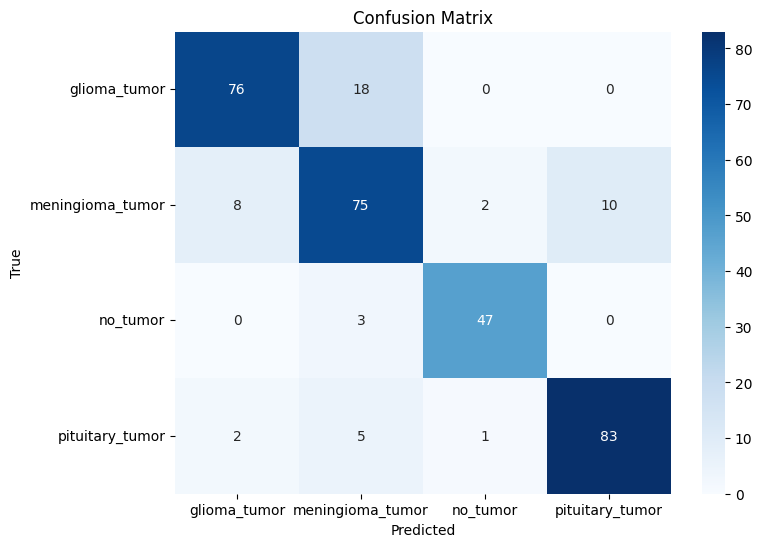

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.88      0.81      0.84        94
meningioma_tumor       0.74      0.79      0.77        95
        no_tumor       0.94      0.94      0.94        50
 pituitary_tumor       0.89      0.91      0.90        91

        accuracy                           0.85       330
       macro avg       0.86      0.86      0.86       330
    weighted avg       0.85      0.85      0.85       330



In [ ]:
# Fazendo previsões no conjunto de teste agora depois do fine-tuning
test_predictions_ft = model.predict(test_generator, verbose=1)

# Convertendo as previsões para as classes
predicted_classes_ft = np.argmax(test_predictions_ft, axis=1)

# Obtendo os rótulos reais
true_classes_ft = test_generator.classes

# Acurácia
accuracy_ft = accuracy_score(true_classes_ft, predicted_classes_ft)
print(f"Acurácia do modelo no conjunto de teste: {accuracy_ft:.4f}")

# Matriz de Confusão
cm = confusion_matrix(true_classes_ft, predicted_classes_ft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de Classificação (Precision, Recall, F1-Score)
class_report_ft = classification_report(true_classes_ft, predicted_classes_ft, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report_ft)